
# Numerical implementation of the deterministic model resolution

We present here the numerical implementation of the deterministic model presented in L. Darrigade and al. All notations are presented in the article. We recal porous media type equations use to model cell densities and reaction-diffusion equations for metabolites concentrations. 
## Porous media type equations

We aim at solving the porous media type equations  : 

\begin{equation}
\begin{cases} 
   \partial_t \rho_l - W \partial_z \left(\phi(z) \rho_l \partial_z \rho   \right) = \sum_k \eta_{k,l} q_k^\infty q_k(z, l, D  \rho, c_b), \\
    \rho_l(0,t) = 0 \text{ if $l\neq sc$,}\\
    \rho_{sc}(0,t) = \rho_{sc}^{bot}, \\
    \partial_z \rho_l(z_{max}, t) = 0.
    \end{cases}
    \label{eq:PME}
\end{equation}

for $ l \in \{'sc','pc','gc','ent'\}$. However this type of equations are not trivial to solve due to the non-linear cross diffusion terms. To be able to simulate we use the kinetic diffusive explicit scheme [(D.Aregba-Driollet & all 2003)](https://www.ams.org/journals/mcom/2004-73-245/S0025-5718-03-01549-7/) and transform the previous equation in the following form : 

\begin{equation}
\partial_t \rho_l -  \partial_z\left(W \phi \partial_z ( \hat{\rho_l} ) \rho_l  - G'\rho_l^2 \right) - \partial_{zz}(G \rho_l^2) = \sum_k \eta_{k,l} q_k^\infty q_k(z, l, D \times \rho, c_b)
\label{eq:PME_scheme_cinetique}
\end{equation} 

with $\hat{\rho_l} = \sum_{k \ne l} \rho_k + \rho_{dcs} $ and $G(z) = \frac{1}{2} W \phi(z) $. This new transport-diffusion form is adapted to the use of the kinetic diffusive scheme to obtain numerical simulations. 

Modification of 20/02/2023 : conservative form for the equations 

## Coupled reaction-diffusion equations

For butyrate $c_b$ concentration we solve :

\begin{equation}
\begin{cases} 
       \partial_t c_b - \sigma_b \partial_{zz} c_b = - \gamma_\beta^\infty \frac{c_o^4c_b}{c_o^4c_b + K_{\beta}^5} \times (\rho_{ent} + \rho_{gc}), \\
    c_b(z_{max}, t) = c_{b,lum}, \\
\partial_z c_b(0,t) = 0. \\
    \end{cases}
    \label{eq:butyrate}
\end{equation}


And for $O_2$ $c_o$ concentration : 
\begin{equation}
\begin{cases} 
   \partial_t c_o - \sigma_o \partial_{zz} c_o = - 4 \gamma_\beta^\infty  \frac{c_o^4c_b}{c_o^4c_b + K_{\beta}^5} \times (\rho_{ent} + \rho_{gc}), \\
   \partial_z c_o(z_{max}, t) = 0,\\
    c_o(0,t) = c_{o,bot}.\\
    \end{cases}
    \label{eq:o_2}
\end{equation}

## Code organisation
User find in this notebook different parts : 
-  Load Libraries and modules 
- Definition of biological and numerical parameters
- Definition of $\phi(z)$, $G(z)$ and space regulation term of cell fate events  
- Initialisations
- Resolution
- Display 
- References 


### Load Libraries and modules 

In [1]:
# Load libraries
import time
import numpy as np
from scipy.integrate import simps

# Load modules 
import module_model_resolution as reso
import util as ut

### Definition of biological and numerical parameters

Biological parameter values are listed in Tab 12/13 from ref L. Darrigade and al  

In [2]:
dict_param = {
    # Geometry
    "Z_max": 200.0,
    "r0": 25.0,
    "eps": 2.5,
    #
    # mecanic interaction
    "W_barre": 6.01 / 8,
    "D_barre": 12.07,
    #
    # sc division
    "q_div_sc": 0.15,
    "K_div_sc": 12.0,
    "l_div_sc": 5.0,
    "K_cont_div_sc": 53.0,
    "l_cont_div_sc": 6.0,
    "K_but_sc": 2,
    "l_but": 5,
    # Differenctiation sc - pc
    "q_sc_pc": 0.2,
    #
    # pc division
    "q_div_pc": 0.22,
    "K_div_pc": 40.0,
    "l_div_pc": 40.0,
    "K_cont_div_pc": 41.0,
    #
    # # Differenciation pc - ent / gc
    "q_pc_gc": 0.25 / 3,
    "q_pc_ent": 0.25,
    "l_pc_ent": 15.0,
    #
    "K_but_pc_dif": 1.5,
    #
    # Extrusion
    "q_ex": 0.34,
    "K_ext": 190.0,
    "l_ext": 15.0,
    "K_cont_ext": 20.0,
    #
    # Boundary condition for densities
    "cond_sc_z0": 0.65,
    "cond_pc_z0": 0,
    "cond_gc_z0": 0,
    "cond_ent_z0": 0,
    #
    # Initial state for DCS cells
    "dcs_zd": 3,
    "dcs_d": 2.25,
    "dcs_zu": 3,
    "dcs_u": -1 / 8,
    "nb_dcs": 12,
    #
    # # Metabolites concentrations
    "sigma_b": 3.6e6,
    "sigma_o": 3.6e6,
    "gamma": 1.6e4 / 15.5,
    "K_b_o": 0.184 * 10 ** 4,
    "c_b_top": 5,
    "c_o_bot": 10,
}

In [3]:
# Definition of numeric parameters 
dict_num = {
    "nz": 400,  # Number of vertices
    "Tmax": 4000,  # maximal time
    "dt": 0.00025,  # initial time step
    "nout": 20000,  # used for the stop criterion of the resolution loop and display
}

# Space step :
dict_num["dz"] = dict_param["Z_max"] / (dict_num["nz"] + 1)

# kinetic diffusif explicit scheme parameters :
dict_num["alpha"] = 0.9  
dict_num["a_m1"] = 0.0 
dict_num["a_0"] = 1  
dict_num["a_1"] = 0.0  
dict_num["a_2"] = 0.0  
dict_num["m"] = (-dict_num["a_2"] + dict_num["a_m1"]) / (
    dict_num["a_0"]
    - dict_num["a_1"]
    - 3 * dict_num["a_2"]
    + 3 * dict_num["a_m1"]
)

### Definition of $\phi(z)$, $G(z)$ and space regulation term of cell fate events  

We recal that $\phi(z)$ allows to take into account the impact of curvature on the top and at the bottom of the crypte on the interaction force, its value is given by  :

\begin{equation}
\label{eq:phi}
\mathcal{\phi}(z):=\begin{cases}
\frac{\frac{f(z)}{r_0}-\frac{f(0)}{r_0}}{1-\frac{f(0)}{r_0}}\quad &\text{ if }z\leq r_0-\epsilon\\
1 \quad &\text{ if }r_0-\epsilon<z<z_{max}-r_0+\epsilon\\
\frac{\frac{f(z_{max})}{r_0}-\frac{f(z)}{r_0}}{\frac{f(z_{max})}{r_0}-1}\quad &\text{ if }z\geq z_{max}-r_0+\epsilon
\end{cases}
\end{equation}

with $f(z)$ the crypt form :

\begin{equation}\label{eq:def_f}
f(z)=\begin{cases}
r_0\sqrt{\frac{z+\epsilon}{r_0}\left(2-\frac{z+\epsilon}{r_0}\right)}\quad &\text{ if }z\leq r_0-\epsilon\\
r_0 \quad &\text{ if }r_0-\epsilon<z<z_{max}-r_0+\epsilon\\
r_0\left(2-\sqrt{\frac{z_{max}-z+\epsilon}{r_0}\left(2-\frac{z_{max}-z+\epsilon}{r_0}\right)}\right)\quad &\text{ if }z\geq z_{max}-r_0+\epsilon
\end{cases}
\end{equation}

In the implementation of the resolution we supposed the existence of a correction term to take into acount the impact of curvature on the local density of cells : $C(z)$. This would give $G(z) = \frac{W \phi(z) C(z)}{2}$. 
In the article (\bold{REF} )this approach is not explored so we assume here that C(z) = 1.

concerning space regulation term of cell fat events we use the piecewise polynomial function $R(y,K,l)$ such as : 

\begin{equation}
R(y,K,\ell) :=
\label{form:regul}
\begin{cases}
0 & \text{if } y \leq K - \ell,\\
-\frac{1}{4\ell^3}y^3 + \frac{3K}{4\ell^3}y^2 - \frac{3K^2 - 3\ell^2}{4l^3} y + \frac{K^3 + 2\ell^3 - 3 K\ell^2}{4\ell^3}     & \text{if } K - \ell \leq  y \leq K + \ell,\\
1  & \text{if } K + \ell \geq y.
\end{cases}
\end{equation}

Several regulations are not time-dependent but only space-dependent, as in the case of Wnt regulations (see table 1)(\bold{REF})

Space variables are stored in a dictionary : dict_space. 

In [4]:
# Vector of space vertices
zn = np.linspace(0, dict_param["Z_max"], dict_num["nz"] + 1)

# Definition of space variable stored in the dictionnary dict_space
dict_space = {
    
    "phi": np.array(
        [
            reso.Get_phi(z, dict_param["Z_max"], dict_param["r0"], dict_param["eps"])
            for z in zn
        ]
    ),
    "phi_prime": np.array(
        [
            reso.Get_phi_prime(z, dict_param["Z_max"], dict_param["r0"], dict_param["eps"])
            for z in zn
        ]
    ),
    "phi_second": np.array(
        [
            reso.Get_phi_second(z, dict_param["Z_max"], dict_param["r0"], dict_param["eps"])
            for z in zn
        ]
    ),

    "C": np.ones(dict_num["nz"] + 1),
    "C_prime": np.zeros(dict_num["nz"] + 1),
    "C_second": np.zeros(dict_num["nz"] + 1),
}

dict_space["G"] = reso.Get_G(dict_space["C"], dict_space["phi"], dict_param["W_barre"])

dict_space["G_prime"] = reso.Get_G_prime(
    dict_space["C"],
    dict_space["C_prime"],
    dict_space["phi"],
    dict_space["phi_prime"],
    dict_param["W_barre"],
)

dict_space["G_second"] = reso.Get_G_second(
    dict_space["C"],
    dict_space["C_prime"],
    dict_space["C_second"],
    dict_space["phi"],
    dict_space["phi_prime"],
    dict_space["phi_second"],
    dict_param["W_barre"],
)

# Regulation function from source terms 
dict_space["R_sc"] = reso.regulation_r(zn, dict_param["K_div_sc"], dict_param["l_div_sc"])
dict_space["R_pc"] = reso.regulation_r(zn, dict_param["K_div_pc"], dict_param["l_div_pc"])
dict_space["R_pc_gc_ent"] = reso.regulation_r(zn, dict_param["K_div_pc"], dict_param["l_pc_ent"])
dict_space["R_ext"] = reso.regulation_r(zn, dict_param["K_ext"], dict_param["l_ext"])


dict_space['z_coord'] = zn 

### Initialisations

We start from an empty crypt : $\rho_{l,0} = 0 \forall l \in \{'sc', 'pc', 'gc','ent'\}$ and from a DCS cell density following the shape : 


\begin{equation}
\label{eq:dcs_shape}
\rho_{dcs}(z) = \frac{N_{dcs}}{\int_{0}^{Z_{max}}\bar{\rho}_{dcs}(z) dz}\bar{\rho}_{dcs}(z)
\end{equation}	
with

\begin{equation*} 	
\bar{\rho}_{dcs}(z) = 
\begin{cases}  
d (z-z_d) + 1  & \mbox{if} \;  z_d - \frac{1}{d} < z < z_d, \\
1 & \mbox{if} \; z_d \leq z \leq z_u, \\
1+ u(z - z_u) & \mbox{if}\; z_u < z < z_u - \frac{1}{u},\\
0 &\mbox{otherwise,}
\end{cases}
\end{equation*}

where $ z_{d}, d>0 , z_{u}, u<0$ and $N_{dcs}$ is the predefined number of DCS cells. 

We also set initial concentration of butyrate and $O_2$ at zero. 


In [5]:
# Initial conditions for densities
dcs_dens = np.array(
    [
        reso.dcs_shape(
            z,
            dict_param["dcs_zd"],
            dict_param["dcs_d"],
            dict_param["dcs_zu"],
            dict_param["dcs_u"],
        )
        for z in zn
    ]
)


rho_dcs_0 = (dict_param["nb_dcs"] / simps(dcs_dens, zn)) * dcs_dens
rho_sc_0 = rho_pc_0 = rho_gc_0 = rho_ent_0 = np.zeros(dict_num["nz"] + 1)

# Initial conditions for concentrations
c_o = c_b =  np.zeros(dict_num["nz"] + 1)

# Resolution variable 
y0 = [rho_sc_0, rho_dcs_0, rho_pc_0, rho_gc_0, rho_ent_0, c_o, c_b]

### Resolution
Time resolution until steady-state. At the final time get the resolution variable $y$, the number of iterations necessary for resolution, densities of cell living a cell fate event (div, diff, ext) and the final time $t$. 

rho_cell_fate is configured as : \[Div_sc, Diff_sc_pc, Div_pc, Diff_pc_gc, Diff_pc_ent, Ext_gc_ent\]

In [ ]:
# May take time (env 1m30)
start_time = time.time()

y, n_iter, rho_cell_fate, t = reso.resolution(y0, dict_param, dict_num, dict_space)

print("CPU time : ",time.time() - start_time)


### Display of results 
#### Comparison between deterministic and stochastic model behaviour 


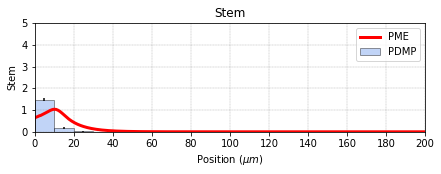

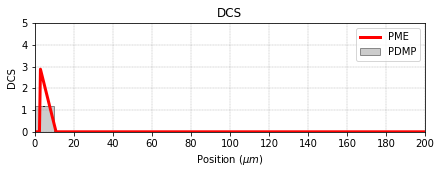

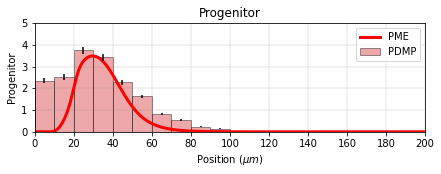

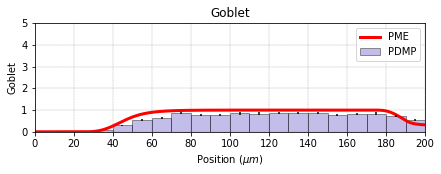

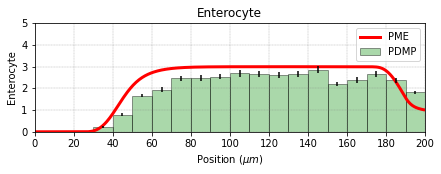

1

In [7]:
# COMPARISON BETWEEN CONTINOUS ANS STOCHASTIC MODEL BEHAVIOUR - Densities
reso.show_comparison_PDMP_PME_density(
    "SIMUS/pop_500_20.p",
    "SIMUS/pop_500_std_20.p",
    zn,
    y,
    colors=ut.colors_density_leo_rgb,
    title = True
)

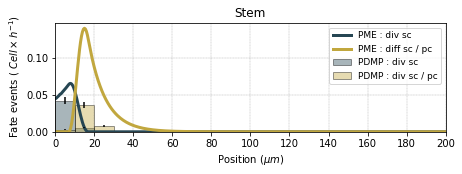

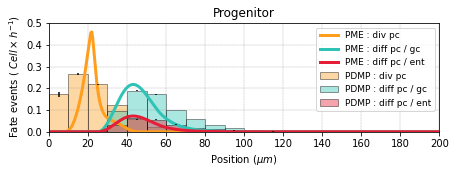

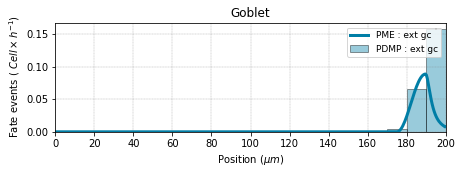

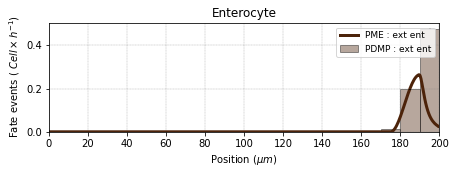

1

In [8]:
# COMPARISON BETWEEN CONTINOUS ANS STOCHASTIC MODEL BEHAVIOUR -cell fate events


reso.show_comparison_PDMP_PME_cell_fate_rates(
    "SIMUS/jumps20.p",
    "SIMUS/jump_std20.p",
    zn,
    y,
    rho_cell_fate,
    colors=ut.colors_cell_fate_rgb,
    title=True
)

#### Densities as steady-state  


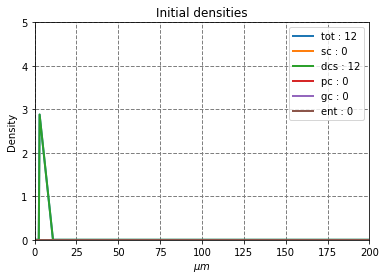

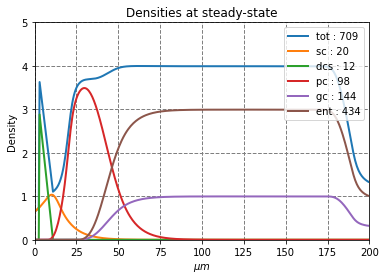

1

<Figure size 432x288 with 0 Axes>

In [10]:
# Show densities
reso.display_densities(zn, y0, 0, title="Initial densities")
reso.display_densities(zn, y, t,title="Densities at steady-state")


#### Cell fate rates at steady-state 


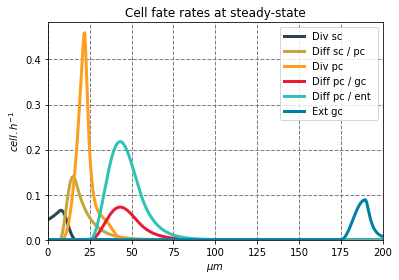

1

<Figure size 432x288 with 0 Axes>

In [11]:
# CELL FATE cell.h^-1
reso.show_cell_fate(
    rho_cell_fate,
    zn,
    y,
    ut.label_cell_fate_latex,
    colors=ut.colors_cell_fate_rgb,
    title="Cell fate rates at steady-state"
)

#### Cells living a cell fate at steady states 

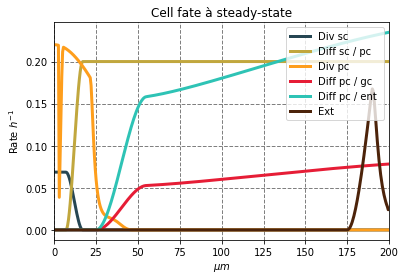

1

<Figure size 432x288 with 0 Axes>

In [12]:

# Cell fate rates
reso.show_cell_fate_rate(
    rho_cell_fate,
    zn,
    ut.label_cell_fate_latex,
    colors=ut.colors_cell_fate_rgb,
    title="Cell fate à steady-state",
)


#### Concentrations at steady-state

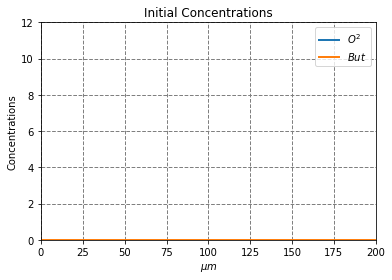

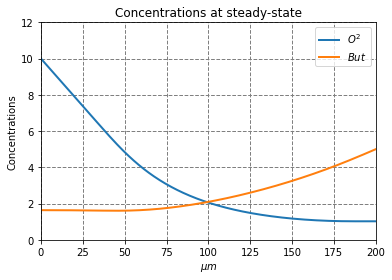

1

<Figure size 432x288 with 0 Axes>

In [13]:
# Show concentrations
reso.display_concentrations(zn, y0, 0,title="Initial Concentrations")
reso.display_concentrations(zn, y, t,title="Concentrations at steady-state")

#### Different DCS shapes 

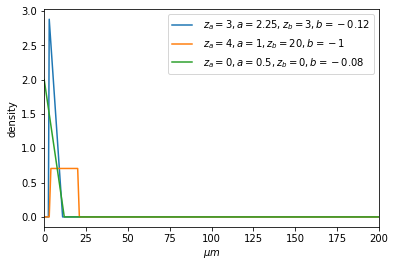

1

<Figure size 432x288 with 0 Axes>

In [14]:
# Different dcs shapes

dict_dcs_shape_ex = {
    "shape_1": [3, 2.25, 3, -1 / 8],
    "shape_2": [4, 1, 20, -1],
    "shape_3": [0, 1 / 2, 0, -1 / 12],
}


reso.show_dcs_shape(zn, dict_dcs_shape_ex, dict_param["nb_dcs"])

## References 

Aregba-Driollet, D., Natalini, R., & Tang, S. (2004). Explicit diffusive kinetic schemes for nonlinear degenerate parabolic systems. Mathematics of computation, 73(245), 63-94. [(D.Aregba-Driollet & all 2003)](https://www.ams.org/journals/mcom/2004-73-245/S0025-5718-03-01549-7/)

Tickzplotlib : Python tool for converting matplotlib figures into PGFPlots (PGF/TikZ)
Nico Schlömer, Sandro Braun, Mads Adrian, danielhkl, Armin Wehrfritz, Samo Penic, Eric Wieser, Aikhjarto, Holger Berndt, Spyros Stathopoulos, Andrew Spott, Daniel Edler, Lukas Müller, Christoph Boeddeker, Gaëtan Cassiers, Lucas Alber, dhoekstra2000, Philipp A., satej soman, … ngc92. (2021). nschloe/tikzplotlib: None (0.9.12). Zenodo. https://doi.org/10.5281/zenodo.5180111

Léo Darrigade. Modélisation du dialogue hôte-microbiote au voisinage de l’épithélium de l'intestin distal. Probabilités [math.PR]. Université Paris-Saclay, 2020. Français. ⟨NNT : 2020UPASM008⟩. ⟨tel-03145857⟩ [(L. Darrigade (2020))](https://tel.archives-ouvertes.fr/tel-03145857)
